In [1]:
import numpy as np
import sklearn
from scipy.ndimage import rotate, interpolation, gaussian_filter
from sklearn.datasets import fetch_openml
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import time

In [4]:
# функции расстояния
def euclidean_distance(X, Y):
    return np.sqrt(
            np.sum(X**2, axis=1)[:, np.newaxis] +
            np.sum(Y**2, axis=1) - 2 * X.dot(Y.T)
            )


def cosine_distance(X, Y):
    dotted = X.dot(Y.T)
    matrix_norms = np.linalg.norm(X, axis=1)
    vector_norm = np.linalg.norm(Y, axis=1)
    matrix_vector_norms = np.outer(matrix_norms, vector_norm)
    neighbors = 1.0 - np.divide(dotted, matrix_vector_norms)
    return neighbors


In [5]:
# класс KNN
class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.metric = metric
        if self.metric not in ['euclidean', 'cosine']:
            raise TypeError(self.metric + ' not euclidean or cosine')
        self.k = k
        self.weights = weights
        if strategy in ['brute', 'kd_tree', 'ball_tree']:
            self.strategy = sklearn.neighbors.NearestNeighbors(
                algorithm=strategy, metric=self.metric)
        elif strategy == 'my_own':
            self.strategy = strategy
        else:
            raise TypeError(strategy + ' unacceptable')
        self.test_block_size = test_block_size

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        if self.strategy != 'my_own':
            self.strategy.fit(X, y)

    def find_kneighbors(self, X, return_distance):
        iter_num = np.size(X, 0) // self.test_block_size
        if np.size(X, 0) % self.test_block_size:
            iter_num += 1
        ind_list = list()
        if return_distance:
            dist_list = list()
        for i in range(iter_num):
            ind_beg = self.test_block_size * i
            ind_end = self.test_block_size * (i + 1)
            if self.strategy == 'my_own':
                if self.metric == 'euclidean':
                    distance_func = euclidean_distance
                elif self.metric == 'cosine':
                    distance_func = cosine_distance
                distance_matrix = distance_func(X[ind_beg:ind_end], self.X_train)
                k_ind_matrix = np.argsort(distance_matrix, axis=1)[:, :self.k]
                ind_list.append(k_ind_matrix)
                if return_distance:
                    dist_list.append(distance_matrix[
                                         np.arange(np.size(k_ind_matrix, 0))[:, np.newaxis],
                                         k_ind_matrix])
            else:
                if return_distance:
                    dist, ind = self.strategy.kneighbors(
                        X[ind_beg:ind_end], n_neighbors=self.k,
                        return_distance=return_distance)
                    dist_list.append(dist)
                    ind_list.append(ind)
                else:
                    ind_list.append(
                        self.strategy.kneighbors(
                            X[ind_beg:ind_end], n_neighbors=self.k,
                            return_distance=return_distance))
        if return_distance:
            return np.concatenate(dist_list), np.concatenate(ind_list)
        else:
            return np.concatenate(ind_list)

    def predict(self, X):
        if self.weights:
            dist, ind = self.find_kneighbors(X, return_distance=True)

            el_weights = 1 / (dist + 10 ** -5)

            res = []
            for i in range(ind.shape[0]):
                indeces = ind[i]
                w = el_weights[i]
                ind_list = []
                for index in indeces:
                    ind_list.append(self.y_train[index])
                counts = np.bincount(ind_list, weights=w)
                y = np.argmax(counts)
                res.append(y)
        else:
            ind = self.find_kneighbors(X, return_distance=False)
            res = []
            for indeces in ind:
                counts = np.bincount(indeces)
                y = np.argmax(counts)
                res.append(y)
        return np.array(res)

In [6]:
# cross validation

def kfold(n, n_folds=3):
    all_idx = range(n)
    folds = np.array_split(all_idx, n_folds)
    res = []
    for k in range(n_folds):
        if k == 0:
            edu = np.hstack(folds[k + 1:])
        elif k == n_folds - 1:
            edu = np.hstack(folds[:k])
        else:
            edu = np.hstack((np.hstack(folds[:k]), np.hstack(folds[k + 1:])))
        val = folds[k]
        res.append((edu, val))
    return res


def knn_cross_val_score(X, y, k_list, cv, **kwargs):
    acc = {}
    for key in k_list:
        acc[key] = np.array([])
    a = KNNClassifier(k=max(k_list), **kwargs)
    if cv == None:
        cv = kfold(X.shape[0], 3)
    for m, i in enumerate(cv):
        a.fit(X[i[0]], y[i[0]])
        dist, kneighbors = a.find_kneighbors(X[i[1]], True)
        for j, k in enumerate(k_list):
            ans = []
            dist_k = dist[:, :k]
            kneighbors_k = kneighbors[:, :k]
            for ind, l in enumerate(kneighbors_k):
                if a.weights:
                    count_el = np.bincount(y[i[0]][l].astype('int64'),
                                           weights=1 / (dist_k[ind] + 0.00001))
                else:
                    count_el = np.bincount(y[i[0]][l].astype('int64'))
                ans.append(str(count_el.argmax()))
            acc[k] = np.append(acc[k],
                               (np.array(ans).astype('int64') ==
                                np.array(y[i[1]]).astype('int64')).sum() / len(i[1]))
    return acc

def knn_cross_val_predict(knn_classifier, num_of_classes, kneighbors):
    if isinstance(kneighbors, tuple):
        dist = kneighbors[0]
        eps = 1e-5
        weights = 1 / (dist + eps)
        classes_of_neigh = knn_classifier.y_train[kneighbors[1]]
        wieghts_of_neigh = np.empty((kneighbors[0].shape[0], num_of_classes), order='F')
        for i in range(num_of_classes):
            mask_of_a_class = classes_of_neigh == i
            wieghts_of_neigh[:, i] = np.sum(weights * mask_of_a_class, axis=1)
        y = np.argmax(wieghts_of_neigh, axis=1)
    else:
        classes_of_neigh = knn_classifier.y_train[kneighbors]
        frequencies_of_classes = np.apply_along_axis(func1d=np.bincount,
                                                     axis=1,
                                                     arr=classes_of_neigh,
                                                     minlength=num_of_classes)
        y = np.argmax(frequencies_of_classes, axis=1)
    return y

Тесты будут проходить с использованием dataset рукопистный цифр fetch_mldata


In [2]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype('int64')
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]


Тест №1
Сравнение времени работы алгоритмов на разных подмножествах признаков

In [ ]:
k = 5
# подмножества
feature_ind = np.arange(np.size(X, 0))
ind_10 = feature_ind[:10]
ind_20 = feature_ind[:20]
ind_100 = feature_ind[:100]
ind_list = [ind_10, ind_20 , ind_100]
# подсчет времени
times = {}
strategies = ['my_own', 'brute', 'kd_tree', 'ball_tree']
for st in strategies:
    knn = KNNClassifier(k, st, metric='euclidean', weights=False, test_block_size=1000)
    times[st] = []
    for ind in ind_list:
        knn.fit(X_train[:, ind], y_train)
        start = time.time()
        knn.find_kneighbors(X_test[:, ind], False)
        times[st].append(time.time() - start)

In [26]:
times

{'my_own': [33.25883889198303, 33.13347411155701, 39.28713059425354],
 'brute': [12.846462488174438, 12.201679229736328, 13.470950841903687],
 'kd_tree': [12.385839462280273, 19.841198682785034, 99.530029296875],
 'ball_tree': [9.141163349151611, 15.503875017166138, 81.69175219535828]}

График для сравнения времени от features & strategies

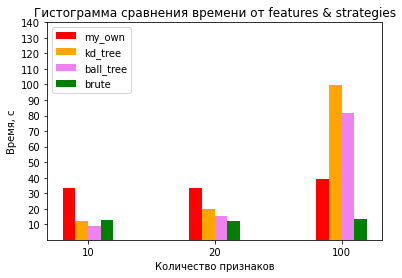

In [27]:
fig, ax = plt.subplots()
index = np.array([1, 2, 3])
bar_width = 0.1

rects1 = ax.bar(index, times['my_own'], bar_width, color='r', label='my_own')
rects2 = ax.bar(index + bar_width, times['kd_tree'], bar_width, color='orange', label='kd_tree')
rects3 = ax.bar(index + 2 * bar_width, times['ball_tree'], bar_width, color='violet', label='ball_tree')
rects4 = ax.bar(index + 3 * bar_width, times['brute'], bar_width, color='green', label='brute')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels((10, 20, 100))
ax.set_xlabel('Количество признаков')
ax.set_yticks(np.arange(10, 150, 10))
ax.set_ylabel('Время, с')
ax.set_title('Гистограмма сравнения времени от features & strategies')
ax.legend()
fig.savefig('gist_1.pdf')

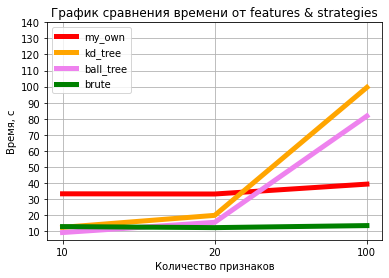

In [32]:
features = [10, 20, 100]
f, ax = plt.subplots()
ax.plot(index, times['my_own'], label="my_own", color='red', linewidth=5)
ax.plot(index, times['kd_tree'], label="kd_tree",color='orange', linewidth=5)
ax.plot(index, times['ball_tree'], label="ball_tree",color='violet', linewidth=5)
ax.plot(index, times['brute'], label="brute", color='green', linewidth=5)
ax.set_xticks(index)
ax.set_xticklabels((10, 20, 100))
ax.set_xlabel('Количество признаков')
ax.set_yticks(np.arange(10, 150, 10))
ax.set_ylabel('Время, с')
ax.set_title('График сравнения времени от features & strategies')
ax.legend()
ax.grid()
f.savefig("lines_1.pdf")

Тест №2. Оценить по кросс-валидации с 3 фолдами точность и время работы KNN

2.а - влияние k(от 1 до 10)

In [29]:
k_list = [i for i in range(1, 11)]
arg_dict = dict()
arg_dict['strategy'] = 'brute'
arg_dict['metric'] = 'euclidean'
arg_dict['weights'] = False
arg_dict['test_block_size'] = 1000
result_dict = knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **arg_dict)
print(result_dict)

{1: array([0.96961515, 0.96725668, 0.96674238]), 2: array([0.96258678, 0.96138516, 0.96211374]), 3: array([0.96991515, 0.96819955, 0.9682424 ]), 4: array([0.9685009 , 0.9657138 , 0.96742811]), 5: array([0.96845804, 0.9660138 , 0.96759954]), 6: array([0.96807234, 0.96459949, 0.96652809]), 7: array([0.9681152 , 0.96524236, 0.9668281 ]), 8: array([0.96670095, 0.9640852 , 0.96622809]), 9: array([0.96614382, 0.96262804, 0.96567094]), 10: array([0.96541527, 0.9626709 , 0.96554236])}


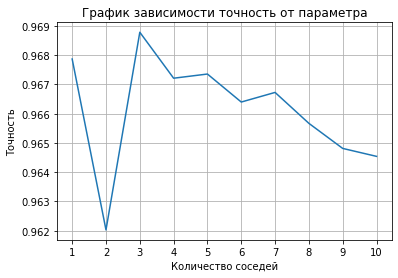

In [31]:
result_dict = {1: np.array([0.96961515, 0.96725668, 0.96674238]), 2: array([0.96258678, 0.96138516, 0.96211374]), 3: array([0.96991515, 0.96819955, 0.9682424 ]), 4: array([0.9685009 , 0.9657138 , 0.96742811]), 5: array([0.96845804, 0.9660138 , 0.96759954]), 6: array([0.96807234, 0.96459949, 0.96652809]), 7: array([0.9681152 , 0.96524236, 0.9668281 ]), 8: array([0.96670095, 0.9640852 , 0.96622809]), 9: array([0.96614382, 0.96262804, 0.96567094]), 10: array([0.96541527, 0.9626709 , 0.96554236])}

# график для k
copy_result_dict = result_dict.copy()
for key in copy_result_dict:
    copy_result_dict[key] = copy_result_dict[key].mean()
k_arr = np.arange(1, 11)
acc_list = list()
for k in k_arr:
    acc_list.append(copy_result_dict[k])
acc_arr = np.array(acc_list)
plt.plot(k_arr, acc_arr)
plt.grid()
plt.xticks(k_list)
plt.xlabel('Количество соседей')
plt.ylabel('Точность')
plt.title('График зависимости точности от параметра')
plt.savefig('k-accuracy(3).pdf')

2.б - Сравнение метрик

In [16]:
start = time.time()
scores_euc = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=None, metric = 'euclidean', strategy='brute', weights=False, test_block_size=2000)
scores_euc['time'] = time.time() -  start
start = time.time()
scores_cosine = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=None, metric='cosine', strategy='brute', weights=False, test_block_size=2000)
scores_cosine['time'] = time.time() -  start

In [19]:
scores_euc

{1: array([0.96895, 0.96675, 0.9667 ]),
 2: array([0.9603 , 0.95995, 0.96125]),
 3: array([0.96955, 0.96825, 0.96715]),
 4: array([0.96705, 0.9667 , 0.9671 ]),
 5: array([0.9681, 0.9673, 0.9672]),
 6: array([0.96555, 0.96495, 0.9657 ]),
 7: array([0.9652, 0.965 , 0.9656]),
 8: array([0.96415, 0.9639 , 0.96525]),
 9: array([0.9637 , 0.9632 , 0.96455]),
 10: array([0.96245, 0.9622 , 0.9637 ]),
 'time': 172.29846096038818}

In [20]:
scores_cosine

{1: array([0.9733 , 0.9708 , 0.97045]),
 2: array([0.96895, 0.9664 , 0.96775]),
 3: array([0.97365, 0.97155, 0.9709 ]),
 4: array([0.9725 , 0.97095, 0.9722 ]),
 5: array([0.97275, 0.97015, 0.9716 ]),
 6: array([0.97195, 0.9697 , 0.97215]),
 7: array([0.97125, 0.96815, 0.97075]),
 8: array([0.97125, 0.96835, 0.97155]),
 9: array([0.97005, 0.967  , 0.9707 ]),
 10: array([0.96935, 0.96615, 0.9707 ]),
 'time': 198.21011996269226}

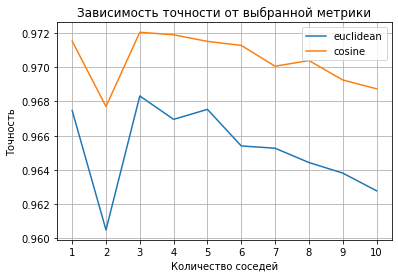

In [33]:
# график
scores_euc_dic = scores_euc.copy()
scores_cosine_dic = scores_cosine.copy()
for key in scores_euc_dic:
    scores_euc_dic[key] = np.mean(scores_euc_dic[key])
    scores_cosine_dic[key] = np.mean(scores_cosine_dic[key])
k_arr = np.arange(1, 11)
euc_list = list()
cosine_list = list()
for k in k_arr:
    euc_list.append(scores_euc_dic[k])
    cosine_list.append(scores_cosine_dic[k])

euc_arr = np.array(euc_list)
cosine_arr = np.array(cosine_list)
plt.plot(k_arr, euc_arr, label='euclidean')
plt.plot(k_arr, cosine_arr,label='cosine')
plt.grid()
plt.legend()
plt.xticks(k_arr)
plt.xlabel('Количество соседей')
plt.ylabel('Точность')
plt.title('Зависимость точности от выбранной метрики')
plt.savefig('k-accuracy(4).pdf')


Тест №3. Сравнить точность с использованием весов и без

In [34]:
start = time.time()
scores_without_weights = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=None, metric = 'cosine', strategy='brute', weights=False, test_block_size=2000)
scores_without_weights['time'] = time.time() -  start
start = time.time()
scores_with_weights = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=None, metric='cosine', strategy='brute', weights=True, test_block_size=2000)
scores_with_weights['time'] = time.time() -  start


In [2]:
scores_with_weights

In [3]:
scores_without_weights

График

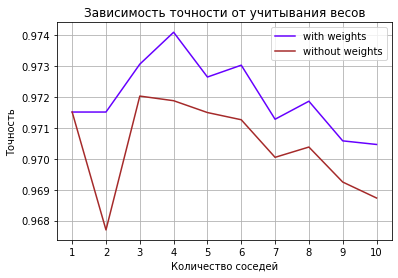

In [5]:
k_arr = np.arange(1, 11)
scores_with_weights_dict = scores_with_weights.copy()
scores_without_weights_dict = scores_without_weights.copy()
for key in scores_with_weights_dict:
    scores_with_weights_dict[key] = np.mean(scores_with_weights_dict[key])
    scores_without_weights_dict[key] = np.mean(scores_without_weights_dict[key])
with_list = list()
without_list = list()
for k in k_arr:
    with_list.append(scores_with_weights_dict[k])
    without_list.append(scores_without_weights_dict[k])

with_arr = np.array(with_list)
without_arr = np.array(without_list)
plt.plot(k_arr, with_arr, color= '#6600ff' ,label='with weights')
plt.plot(k_arr, without_arr, color='brown',label='without weights')
plt.grid()
plt.legend()
plt.xticks(k_arr)
plt.xlabel('Количество соседей')
plt.ylabel('Точность')
plt.title('Зависимость точности от учитывания весов')
plt.savefig('k-weights(5).pdf')

Тест №4. Применить алгоритм к данным. Сделать матрицу ошибок. Проанализировать черты ошибок.

In [65]:
knn = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [66]:
acc = np.sum(pred == y_test) / np.size(y_test, 0)
acc

0.9752

In [26]:
from sklearn.metrics import confusion_matrix

# функция взята с сайта https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_name=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param save_name: name for your file

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(save_name, format='pdf', bbox_inches='tight')
    plt.show()
# функция взята с сайта https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

#cm = confusion_matrix(y_test, pred)
#pl = plot_confusion_matrix(cm, normalize = False, target_names = np.unique(y_test),
#                      title = "Confusion Matrix", save_name='Confusion Matrix1.pdf')

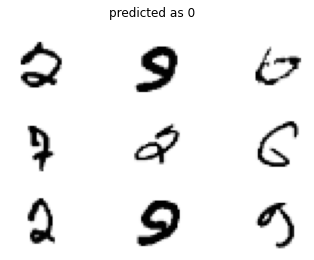

In [84]:
y_ind = np.arange(10000)
i_arr = np.arange(10)
i = 0
test = y_test != i
y_pred = pred == i
curr = test * y_pred
i_rec = y_ind[curr]
z = np.arange(np.size(i_rec))
np.random.shuffle(z)
i_rec_9 = i_rec[z[:10]]
fig = plt.figure()
for j in range(1, 10):
    ax = fig.add_subplot(3, 3, j)
    plt.imshow(X_test[i_rec_9[j]].reshape(28, 28), cmap="Greys")
    plt.axis('off')
fig.suptitle('predicted as 0')
plt.savefig('img0.pdf')

Тест №5. Размножение обучаемой выборки с помощью поворотов, смещений и применением гауссокого фильтра.

5.1 Величина поворота

In [18]:
def my_rotate(arr, angle):
    return rotate(arr.reshape(28, 28), angle=angle, reshape=False).reshape(784)
cv = kfold(X_train.shape[0])

In [32]:
rotations = [-5,5,-10,10,-15,15]

cross_val_rotations = np.empty((len(rotations), len(cv)), dtype=float)
for rotation_num, rotation in enumerate(rotations):
    for split_num, split in enumerate(cv):
        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=1000)
        my_own.fit(X_train[split[0]], y_train[split[0]])
        kneighbors = my_own.find_kneighbors(X_train[split[1]], True)

        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=1000)
        X_train_rotated = np.apply_along_axis(func1d=my_rotate, axis=1, arr=X_train[split[0]], angle=rotation)
        my_own.fit(X_train_rotated, y_train[split[0]])
        kneighbors_last = my_own.find_kneighbors(X_train[split[1]], True)
        kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                      np.hstack((kneighbors[1], kneighbors_last[1])))
        nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
        indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
        indices = (indices[0], nearest_neighbors_pos.ravel())
        distances = kneighbors[0][indices].reshape(-1, my_own.k)
        indices = kneighbors[1][indices].reshape(-1, my_own.k)
        y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                        num_of_classes=10,
                                        kneighbors=(distances, indices))
        cross_val_rotations[rotation_num][split_num] = np.mean(y_predicted == y_train[split[1]])

In [33]:
print(cross_val_rotations)
best_rotation = rotations[np.argmax(np.mean(cross_val_rotations, axis=1))]
best_rotation

[[0.9761  0.97335 0.97395]
 [0.9767  0.97425 0.9747 ]
 [0.97735 0.9744  0.97485]
 [0.97735 0.9755  0.976  ]
 [0.9764  0.97305 0.9729 ]
 [0.97655 0.9756  0.97535]]


10

5.2. Сдвиги

In [68]:
def my_shift(arr, shift):
    #return interpolation.shift(arr.reshape((28, 28)), shift=shift).ravel()[:784].reshape(784)
    return interpolation.shift(arr.reshape((28, 28)), shift=shift).reshape(784)

In [39]:
directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
shift_amount = np.arange(3) + 1
shifts = (directions * shift_amount[:, np.newaxis, np.newaxis]).ravel().reshape(-1, 2)

cross_val_shifts = np.empty((len(shifts), len(cv)), dtype=float)
for shift_num, shift in enumerate(shifts):
    for split_num, split in enumerate(cv):
        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        my_own.fit(X_train[split[0]], y_train[split[0]])
        kneighbors = my_own.find_kneighbors(X_train[split[1]], True)

        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        X_train_shifted = np.apply_along_axis(func1d=my_shift, axis=1, arr=X_train[split[0]], shift=shift)
        my_own.fit(X_train_shifted, y_train[split[0]])
        kneighbors_last = my_own.find_kneighbors(X_train[split[1]], True)
        kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                      np.hstack((kneighbors[1], kneighbors_last[1])))
        nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
        indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
        indices = (indices[0], nearest_neighbors_pos.ravel())
        distances = kneighbors[0][indices].reshape(-1, my_own.k)
        indices = kneighbors[1][indices].reshape(-1, my_own.k)
        y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                        num_of_classes=10,
                                        kneighbors=(distances, indices))
        cross_val_shifts[shift_num][split_num] = np.mean(y_predicted == y_train[split[1]])


In [40]:
print(cross_val_shifts)
best_shift = shifts[np.argmax(np.mean(cross_val_shifts, axis=1))]
best_shift

[[0.9768  0.97575 0.9747 ]
 [0.9778  0.9762  0.9756 ]
 [0.9768  0.9739  0.9753 ]
 [0.9764  0.9741  0.9738 ]
 [0.97675 0.97435 0.97495]
 [0.97695 0.97415 0.97425]
 [0.97595 0.97395 0.97365]
 [0.97615 0.97355 0.97385]
 [0.97585 0.9738  0.97425]
 [0.97575 0.9733  0.9736 ]
 [0.97545 0.9733  0.97395]
 [0.97555 0.9732  0.97365]]


array([0, 1])

5.3.Сглаживание.

In [41]:
smooths = np.sqrt(np.array([0.5, 1, 1.5]))

cross_val_gaussian = np.empty((len(smooths), len(cv)), dtype=float)
for smooth_num, smooth in enumerate(smooths):
    for split_num, split in enumerate(cv):
        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        my_own.fit(X_train[split[0]], y_train[split[0]])
        kneighbors = my_own.find_kneighbors(X_train[split[1]], True)

        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        X_train_smoothed = np.apply_along_axis(func1d=gaussian_filter, axis=1, arr=X_train[split[0]], sigma=smooth)
        my_own.fit(X_train_smoothed, y_train[split[0]])
        kneighbors_last = my_own.find_kneighbors(X_train[split[1]], True)
        kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                      np.hstack((kneighbors[1], kneighbors_last[1])))
        nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
        indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
        indices = (indices[0], nearest_neighbors_pos.ravel())
        distances = kneighbors[0][indices].reshape(-1, my_own.k)
        indices = kneighbors[1][indices].reshape(-1, my_own.k)
        y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                        num_of_classes=10,
                                        kneighbors=(distances, indices))
        cross_val_gaussian[smooth_num][split_num] = np.mean(y_predicted == y_train[split[1]])

In [42]:
print(cross_val_gaussian)
best_smooth = smooths[np.argmax(np.mean(cross_val_gaussian, axis=1))]
best_smooth

[[0.9754  0.9732  0.9727 ]
 [0.9761  0.9737  0.97405]
 [0.97635 0.97375 0.9744 ]]


1.224744871391589

Рассмотрим наилучшие значения по каждому изменению

In [23]:
best_rotation = 10
best_smooth = 1.5 ** 0.5
best_shift = np.array([0, 1])

In [30]:
my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
my_own.fit(X_train, y_train)
kneighbors = my_own.find_kneighbors(X_test, True)

my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
X_train_shifted = np.apply_along_axis(func1d=my_rotate, axis=1, arr=X_train, angle=10)
my_own.fit(X_train_shifted, y_train)
kneighbors_last = my_own.find_kneighbors(X_test, True)
kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
              np.hstack((kneighbors[1], kneighbors_last[1])))

nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
indices = (indices[0], nearest_neighbors_pos.ravel())
distances = kneighbors[0][indices].reshape(-1, my_own.k)
indices = kneighbors[1][indices].reshape(-1, my_own.k)
y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                    num_of_classes=10,
                                    kneighbors=(distances, indices))
accuracy = np.mean(y_predicted == y_test)

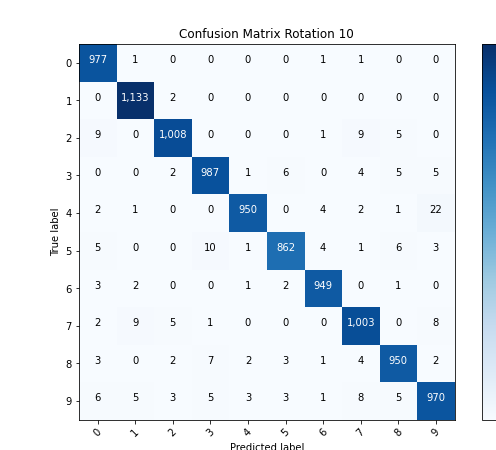

In [31]:
cm = confusion_matrix(y_test, y_predicted)
pl = plot_confusion_matrix(cm, normalize = False, target_names = np.unique(y_test),
                      title = "Confusion Matrix Rotation 10", save_name='Confusion Matrix Rotation.pdf')

Тест №6. Применим подходы обработки на тестовую выборку

6.1. Величина поворота

In [71]:
rotations = [5, -5, 10, -10, 15, -15]

cross_val_rotations = np.empty((len(rotations), len(cv)), dtype=float)
for rotation_num, rotation in enumerate(rotations):
    for split_num, split in enumerate(cv):
        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        my_own.fit(X_train[split[0]], y_train[split[0]])
        kneighbors = my_own.find_kneighbors(X_train[split[1]], True)

        kneighbors_last = my_own.find_kneighbors(np.apply_along_axis(func1d=my_rotate,
                                                                     axis=1,
                                                                     arr=X_train[split[1]],
                                                                     angle=rotation), True)
        kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                      np.hstack((kneighbors[1], kneighbors_last[1])))
        nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
        indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
        indices = (indices[0], nearest_neighbors_pos.ravel())
        distances = kneighbors[0][indices].reshape(-1, my_own.k)
        indices = kneighbors[1][indices].reshape(-1, my_own.k)
        y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                            num_of_classes=10,
                                            kneighbors=(distances, indices))
        cross_val_rotations[rotation_num][split_num] = np.mean(y_predicted == y_train[split[1]])

6.2 Сдвиги

In [73]:
directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
shift_amount = np.arange(3) + 1
shifts = (directions * shift_amount[:, np.newaxis, np.newaxis]).ravel().reshape(-1, 2)
cross_val_shifts = np.empty((len(shifts), len(cv)), dtype=float)
for shift_num, shift in enumerate(shifts):
    for split_num, split in enumerate(cv):
        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        my_own.fit(X_train[split[0]], y_train[split[0]])
        kneighbors = my_own.find_kneighbors(X_train[split[1]], True)

        kneighbors_last = my_own.find_kneighbors(np.apply_along_axis(func1d=my_shift,
                                                                     axis=1,
                                                                     arr=X_train[split[1]],
                                                                     shift=shift), True)
        kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                      np.hstack((kneighbors[1], kneighbors_last[1])))
        nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
        indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
        indices = (indices[0], nearest_neighbors_pos.ravel())
        distances = kneighbors[0][indices].reshape(-1, my_own.k)
        indices = kneighbors[1][indices].reshape(-1, my_own.k)
        y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                                         num_of_classes=10,
                                                         kneighbors=(distances, indices))
        cross_val_shifts[shift_num][split_num] = np.mean(y_predicted == y_train[split[1]])

In [74]:

smooths = np.sqrt(np.array([0.5, 1, 1.5]))


cross_val_gaussian = np.empty((len(smooths), len(cv)), dtype=float)
for smooth_num, smooth in enumerate(smooths):
    for split_num, split in enumerate(cv):
        my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
        my_own.fit(X_train[split[0]], y_train[split[0]])
        kneighbors = my_own.find_kneighbors(X_train[split[1]], True)

        kneighbors_last = my_own.find_kneighbors(np.apply_along_axis(func1d=gaussian_filter,
                                                                     axis=1,
                                                                     arr=X_train[split[1]],
                                                                     sigma=smooth), True)
        kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                      np.hstack((kneighbors[1], kneighbors_last[1])))
        nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
        indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
        indices = (indices[0], nearest_neighbors_pos.ravel())
        distances = kneighbors[0][indices].reshape(-1, my_own.k)
        indices = kneighbors[1][indices].reshape(-1, my_own.k)
        y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                            num_of_classes=10,
                                            kneighbors=(distances, indices))
        cross_val_gaussian[smooth_num][split_num] = np.mean(y_predicted == y_train[split[1]])

In [75]:
cross_val_rotations

array([[0.97545, 0.97325, 0.97365],
       [0.9755 , 0.9732 , 0.97365],
       [0.97545, 0.9732 , 0.97365],
       [0.97545, 0.9732 , 0.97365],
       [0.97545, 0.9732 , 0.97365],
       [0.97545, 0.9732 , 0.97365]])

In [76]:
cross_val_shifts


array([[0.9768 , 0.9739 , 0.9753 ],
       [0.9764 , 0.9741 , 0.9738 ],
       [0.9768 , 0.97575, 0.9747 ],
       [0.9778 , 0.9762 , 0.9756 ],
       [0.97595, 0.97395, 0.97365],
       [0.97615, 0.97355, 0.97385],
       [0.97675, 0.97445, 0.975  ],
       [0.97695, 0.97415, 0.97425],
       [0.9755 , 0.97325, 0.97395],
       [0.97555, 0.9732 , 0.97365],
       [0.97585, 0.9737 , 0.97415],
       [0.97575, 0.9733 , 0.9736 ]])

In [77]:
cross_val_gaussian

array([[0.975  , 0.9718 , 0.9716 ],
       [0.97365, 0.97   , 0.96985],
       [0.9709 , 0.9675 , 0.9672 ]])

In [78]:
best_smooth = smooths[np.argmax(np.mean(cross_val_gaussian, axis=1))]
best_rotation = rotations[np.argmax(np.mean(cross_val_rotations, axis=1))]
best_shift = shifts[np.argmax(np.mean(cross_val_shifts, axis=1))]

In [81]:
best_smooth

0.7071067811865476

In [80]:
best_rotation

5

In [79]:
best_shift

array([ 0, -1])

In [40]:
my_own = KNNClassifier(k=4, strategy='brute',metric='cosine',weights=True,test_block_size=2000)
my_own.fit(X_train, y_train)
kneighbors = my_own.find_kneighbors(X_test, True)
for rot in smooths:
    kneighbors_last = my_own.find_kneighbors(np.apply_along_axis(func1d=gaussian_filter,
                                                                 axis=1,
                                                                 arr=X_test,
                                                                 sigma=rot), True)
    kneighbors = (np.hstack((kneighbors[0], kneighbors_last[0])),
                  np.hstack((kneighbors[1], kneighbors_last[1])))

nearest_neighbors_pos = np.argpartition(kneighbors[0], np.arange(my_own.k), axis=1)[:, :my_own.k]
indices = np.where((nearest_neighbors_pos == nearest_neighbors_pos))
indices = (indices[0], nearest_neighbors_pos.ravel())
distances = kneighbors[0][indices].reshape(-1, my_own.k)
indices = kneighbors[1][indices].reshape(-1, my_own.k)
y_predicted = knn_cross_val_predict(knn_classifier=my_own,
                                    num_of_classes=10,
                                    kneighbors=(distances, indices))
final_accuracy_1 = np.mean(y_predicted == y_test)

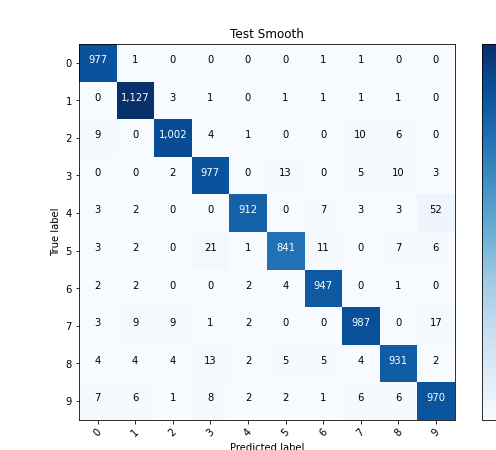

In [41]:
cm = confusion_matrix(y_test, y_predicted)
pl = plot_confusion_matrix(cm, normalize = False, target_names = np.unique(y_test),
                      title = "Test Smooth", save_name='Confusion Matrix Smooth(Test).pdf')
